<a href="https://colab.research.google.com/github/nilanahar/MMAI_894_DeepLearning_Project_TeamRosedale/blob/main/MMAI_894_Team_Project_v1_2_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment

#### Packages to Load

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
import json
import joblib
import os
import re
from tqdm import tqdm
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.preprocessing import image
from PIL import Image
import torch
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

#### Set Directories

In [9]:
# define my google drive
drive.mount("/content/drive", force_remount=True)

# Define the file path (adjust it to match your folder structure)
training_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/MultipleChoice_abstract_v002_train2015_questions.json"
training_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/OpenEnded_abstract_v002_train2015_questions.json"
training_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/abstract_v002_train2015_annotations.json"
training_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/scene_img_abstract_v002_train2015"

validation_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/MultipleChoice_abstract_v002_val2015_questions.json"
validation_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/OpenEnded_abstract_v002_val2015_questions.json"
validation_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/abstract_v002_val2015_annotations.json"
validation_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/scene_img_abstract_v002_val2015"

testing_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/MultipleChoice_abstract_v002_test2015_questions.json"
testing_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/OpenEnded_abstract_v002_test2015_questions.json"
testing_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/scene_img_abstract_v002_test2015"

Mounted at /content/drive


#### Functions to Use as You Go

In [6]:
# Function to load multiple JSON data
def load_json(file_path):
    if file_path: # Check if file_path is not None
        with open(file_path, 'r') as f:
            return json.load(f)
    else:
        return None # or handle the None case differently, like returning an empty dictionary

def json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path):
    # Now you can use this function to load multiple JSON files
    mcq_json_data = load_json(mcq_file_path)
    oeq_json_data = load_json(oeq_file_path)

    mcq_df = pd.json_normalize(mcq_json_data['questions'])[['image_id', 'question_id', 'question', 'multiple_choices']]
    oeq_df = pd.json_normalize(oeq_json_data['questions'])[['image_id', 'question_id', 'question']]

    # Check if answers_file_path is None
    if answers_file_path is not None:
        answers_json_data = load_json(answers_file_path)
        answers_df = pd.json_normalize(answers_json_data['annotations'])[['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type']]
    else:
        # Create an empty DataFrame if answers_file_path is None
        answers_df = pd.DataFrame(columns=['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type'])

    return mcq_df, oeq_df, answers_df


def tabularize_answers_df(answers_df):
    # Create a unique identifier for each row to track back after transformations
    answers_df['index'] = answers_df.index
    # Explode the 'answers' column into separate rows, while keeping other columns intact
    answers_expanded_df = answers_df.explode('answers')
    # normalization as before
    answers_details = pd.json_normalize(answers_expanded_df['answers'])
    answers_details['index'] = answers_expanded_df.index
    # Concatenate back to the actual answers DataFrame
    answers_expanded_df = pd.merge(answers_df, answers_details, on='index', how='left')
    answers_merged_df = answers_expanded_df[['image_id', 'question_id', 'question_type',
                                              'multiple_choice_answer', 'answer_type',
                                              'answer', 'answer_id', 'answer_confidence',
                                              'index']]
    answers_merged_df = answers_merged_df.rename(columns={'multiple_choice_answer': 'mcq_answer',
                                                              'answer_type': 'mcqa_type',
                                                              'answer': 'oeq_answer',
                                                              'answer_id': 'oeqa_id',
                                                              'answer_confidence': 'oeqa_confidence'
                                                              })

    return answers_merged_df

# Function to extract features from multiple JSON files
def extract_qna_features(mcq_file_path, oeq_file_path, answers_file_path):

    mcq_df, oeq_df, answers_df = json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path)
    answers_merged_df = tabularize_answers_df(answers_df)

    questions_merged_df = pd.merge(mcq_df, oeq_df, on=['image_id', 'question_id'], how='left', suffixes=('_oeq', '_mcq'))
    final_qna_df = pd.merge(questions_merged_df, answers_merged_df, on=['image_id', 'question_id'], how='left')

    return mcq_df, oeq_df, answers_merged_df, final_qna_df


# Function to extract last five digits from file names
def extract_last_five_digits(filename):
    match = re.search(r'(\d{5})\.png$', filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Filename {filename} does not match the expected pattern.")

def extract_image_features(model, images_file_path):
    images_features_dict = {}
    for img_name in tqdm(os.listdir(images_file_path)):
        img_path = os.path.join(images_file_path, img_name)

        # Extract image_id (adjust slice according to your filename structure)
        image_id = img_name[-9:-4]  # Example: extracting last 5 digits before file extension

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

        # Extract features and store them in the dictionary
        features = model.predict(x)
        images_features_dict[image_id] = features.flatten()

    images_features_df = pd.DataFrame.from_dict(images_features_dict, orient='index')
    images_features_df.reset_index(inplace=True)
    images_features_df.rename(columns={'index': 'image_id'}, inplace=True)

    return images_features_df

# Function to extract features using AlexNet
def extract_image_features_alexnet(images_file_path):
    # Load the pre-trained AlexNet model from PyTorch
    model = models.alexnet(pretrained=True)
    model.eval()  # Set the model to evaluation mode

    # Transformation pipeline for AlexNet
    preprocess = transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Center crop to 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet dataset
    ])

    images_features_dict = {}

    # Iterate through images in the provided file path
    for img_name in tqdm(os.listdir(images_file_path)):
        img_path = os.path.join(images_file_path, img_name)

        # Extract image_id using the last 5 digits before file extension
        image_id = extract_last_five_digits(img_name)

        # Load and preprocess the image using PIL and torchvision transformations
        img = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
        img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

        # Extract features using AlexNet
        with torch.no_grad():  # Disable gradient computation
            features = model(img_tensor).numpy().flatten()  # Convert to NumPy and flatten

        # Store features in dictionary with image_id as the key
        images_features_dict[image_id] = features

    # Convert the dictionary to a pandas DataFrame
    images_features_df = pd.DataFrame.from_dict(images_features_dict, orient='index')
    images_features_df.reset_index(inplace=True)
    images_features_df.rename(columns={'index': 'image_id'}, inplace=True)

    return images_features_df


def complete_datasets(qna_df, images_features_df):
    qna_df = qna_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df = images_features_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df['image_id'] = images_features_df['image_id'].astype(int)
    # Merge the 3 dataframes into one (base dataset is image_df (unique), left join qna on image id)
    complete_training_set = pd.merge(images_features_df, qna_df, on='image_id', how='left')
    return complete_training_set


def filter_choices_by_cosine_similarity(row):
  # Step 1: initialize
    question = row['question']
    choices = row['multiple_choices']  # Assume 'multiple_choices' column has a list of answer options

    # Convert question and choices into a single corpus
    corpus = [question] + choices

    # Step 2: Vectorize the corpus using TF-IDF
    vectorizer = TfidfVectorizer().fit(corpus)  # Fit on the full corpus
    vectors = vectorizer.transform(corpus).toarray()  # Transform into TF-IDF vectors

    # Step 3: Calculate cosine similarity between the question and each choice
    similarity_scores = cosine_similarity([vectors[0]], vectors[1:])[0]

    # Step 4: Retain choices with a high similarity score (e.g., > 0.3)
    threshold = 0.3
    filtered_choices = [choices[i] for i, score in enumerate(similarity_scores) if score >= threshold]

    # Step 5: If no choices pass the threshold, keep original choices to avoid empty options
    return filtered_choices if filtered_choices else choices



#### Define Constants

In [ ]:
### Load the pre-trained model that you wish to use to extract image features ###
# model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Step 1: Data Collection

### 1.1 Training Datasets

#### 1.1.1 Extracting Questions & Answers

In [ ]:
train_mcq_df, train_oeq_df, train_answers_merged_df, train_final_qna_df = extract_qna_features(training_mcq_file_path, training_oeq_file_path, training_answers_file_path)
train_final_qna_df.head()

,image_id,question_id,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,old person,1,maybe,0
1,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,man,2,maybe,0
2,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,man,3,yes,0
3,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,man,4,yes,0
4,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,old man,5,yes,0


##### Save Workspace

In [ ]:
# Save the dataframes to Google Drive folder wherever you want to save
joblib.dump(train_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib']

#### 1.1.2 Extracting Images' Features


In [ ]:
train_images_features_df = extract_image_features_alexnet(training_images_file_path)

##### Save Workspace

In [ ]:
# Save the dataframes to Google Drive folder wherever you want to save
joblib.dump(train_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")

#### 1.1.3 Complete Training Dataset

##### Load Workspace

In [ ]:
train_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")
train_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")
train_images_df.shape

(20000, 2049)

In [ ]:
train_complete_df = complete_datasets(train_qna_df, train_images_df)
train_complete_df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,7,yes,13752
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,beige,8,yes,13752
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,tan,9,yes,13752
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,10,yes,13752
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,How is the equipments with bars called?,"[get warm, yes, playful, pug, red, fitness sys...",How is the equipments with bars called?,how,monkey bars,other,monkey bars,1,yes,13753


##### Save Workspace

In [ ]:
joblib.dump(train_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib']

### 1.2 Validation Datasets

#### 1.2.1 Extracting Questions & Answers


In [ ]:
valid_mcq_df, valid_oeq_df, valid_answers_merged_df, valid_final_qna_df = extract_qna_features(validation_mcq_file_path, validation_oeq_file_path, validation_answers_file_path)
valid_final_qna_df.head()

,image_id,question_id,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,1,yes,0
1,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,2,maybe,0
2,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,3,yes,0
3,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,4,yes,0
4,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,5,yes,0


##### Save Workspace

In [ ]:
joblib.dump(valid_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib']

#### 1.2.2 Extracting Images' Features

In [ ]:
# Irfan update this part same as 1.1.2, and do the same in 1.3.2
valid_images_features_df = extract_image_features(model, validation_images_file_path)

In [ ]:
valid_images_features_df.shape

##### Save Workspace

In [ ]:
# Save the dataframes to Google Drive folder wherever you want to save
joblib.dump(valid_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")

#### 1.2.3  Complete Validation Dataset

##### Load Workspace

In [ ]:
valid_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")
valid_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")
valid_images_df.shape

(10000, 2049)

In [ ]:
valid_complete_df = complete_datasets(valid_qna_df, valid_images_df)
valid_complete_df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,8,yes,22585
1,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,9,yes,22585
2,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,10,yes,22585
3,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the curtains match?,"[smiling, 4, for fun, no, forest, 3, sandwich ...",Do the curtains match?,do the,yes,yes/no,yes,1,yes,22586
4,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,6,yes,22585


##### Save Workspace

In [ ]:
joblib.dump(valid_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib']

### 1.3 Testing Datasets

#### 1.3.1 Extracting Questions & Answers

In [ ]:
test_mcq_df, test_oeq_df, test_answers_df = json_to_pdDf(testing_mcq_file_path, testing_oeq_file_path, None)
test_final_qna_df = pd.merge(test_mcq_df, test_oeq_df, on=['image_id', 'question_id'], how='left', suffixes=('_oeq', '_mcq'))
test_final_qna_df.head()

,image_id,question_id,question_oeq,multiple_choices,question_mcq
0,39456,394560,What color are the chairs?,"[red, 4, 3, plates, brown, yellow, green, stan...",What color are the chairs?
1,39456,394561,Is the man asleep?,"[3, blue, 4, no, anger, white, 2, red, yes, on...",Is the man asleep?
2,39456,394562,What is on the table?,"[white, on sidewalk, salt and pepper, 3, yes, ...",What is on the table?
3,47922,479220,How many bushes are in the background?,"[blue, 1, 3, 40, dog, 10, 2, sun rays, red, ye...",How many bushes are in the background?
4,47922,479221,What are they playing?,"[yes, soccer, on man's head, frisbee, golf, mo...",What are they playing?


##### Save Workspace

In [ ]:
joblib.dump(test_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib']

#### 1.3.2 Extracting Images' Features

In [ ]:
test_images_features_df = extract_image_features(model, testing_images_file_path)

##### Save Workspace

In [ ]:
joblib.dump(test_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/images_features.joblib")

#### 1.3.3 Complete Testing Dataset

##### Load Workspace

In [ ]:
test_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib")
test_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Testing/images_features.joblib")
test_images_df.shape

In [ ]:
test_complete_df = complete_datasets(valid_qna_df, valid_images_df)
test_complete_df.head()

##### Save Workspace

In [ ]:
joblib.dump(test_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/complete_testing_set_tabular.joblib")









<space>

# Step 2: Data Preprocessing

### 2.1 Exploratory Data Analysis (EDA)

##### Load Workspace

In [ ]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,7,yes,13752
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,beige,8,yes,13752
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,tan,9,yes,13752
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,10,yes,13752
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,How is the equipments with bars called?,"[get warm, yes, playful, pug, red, fitness sys...",How is the equipments with bars called?,how,monkey bars,other,monkey bars,1,yes,13753


In [ ]:
df_train.describe()

,image_id,0,1,2,3,4,5,6,7,8,...,2041,2042,2043,2044,2045,2046,2047,question_id,oeqa_id,index
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,9999.500000,0.368133,0.562798,0.189160,1.131099,0.287509,1.025322,0.400451,0.428999,1.741150,...,0.512197,0.333506,0.284014,0.967161,2.489452,1.503139,0.375383,99996.000000,5.500000,29999.500000
std,5773.507496,0.293375,0.449849,0.216740,0.843174,0.299742,0.657296,0.385518,0.401190,1.202991,...,0.408730,0.348426,0.321815,0.671971,0.985114,0.875703,0.359627,57735.074965,2.872284,17320.522507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.082576,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4999.750000,0.149581,0.225844,0.026454,0.476878,0.061539,0.530234,0.113554,0.127332,0.744821,...,0.196240,0.086804,0.048282,0.493587,1.771949,0.844923,0.117912,49998.000000,3.000000,14999.750000
50%,9999.500000,0.298245,0.454610,0.115133,0.947439,0.191205,0.911144,0.292274,0.319505,1.508590,...,0.427935,0.227463,0.172276,0.828852,2.465235,1.363421,0.276495,99996.000000,5.500000,29999.500000
75%,14999.250000,0.515346,0.787396,0.282057,1.608470,0.422840,1.391931,0.572293,0.613933,2.550294,...,0.731140,0.462280,0.407972,1.276365,3.153654,2.013003,0.522994,149994.000000,8.000000,44999.250000
max,19999.000000,2.701372,3.603620,2.023512,5.834865,2.574666,5.573476,3.550356,3.802674,6.918488,...,3.508812,4.013538,2.667436,6.289944,7.810620,6.846087,4.155842,199992.000000,10.000000,59999.000000


In [ ]:
# Check if two specific columns are identical in the DataFrame
are_questions_columns_equal = df_train['question_oeq'].equals(df_train['question_mcq'])  # Replace 'question_x' and 'question_y' with your actual column names

# Print the result
print("Are 'question_oeq' and 'question_mcq' identical? : ", "Yes" if are_questions_columns_equal else "No")

Are 'question_oeq' and 'question_mcq' identical? :  Yes


In [ ]:
df_train['question'] = df_train['question_oeq']
df_valid['question'] = df_valid['question_oeq']

df_train = df_train.drop(columns=['question_oeq', 'question_mcq'])
df_valid = df_valid.drop(columns=['question_oeq', 'question_mcq'])

In [ ]:
# Find the most common questions
most_common_questions = df_train['question'].value_counts().head(10)
print("Most common questions:")
print(most_common_questions)

Most common questions:
question
What color is the rug?             3100
What color is the dog?             2760
What color is the couch?           2460
What is on the table?              2450
What is the dog doing?             2000
What color is the cat?             1910
What color are the curtains?       1820
Where is the dog?                  1750
What is the woman doing?           1490
How many clouds are in the sky?    1460
Name: count, dtype: int64


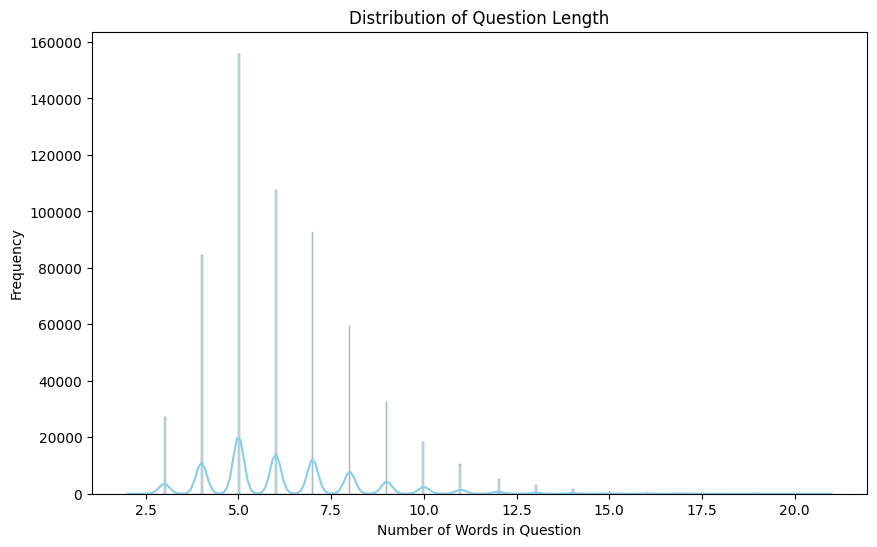

In [ ]:
# Analyze Question Length
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_train['question_length'], kde=True, color='skyblue')
plt.title('Distribution of Question Length')
plt.xlabel('Number of Words in Question')
plt.ylabel('Frequency')
plt.show()

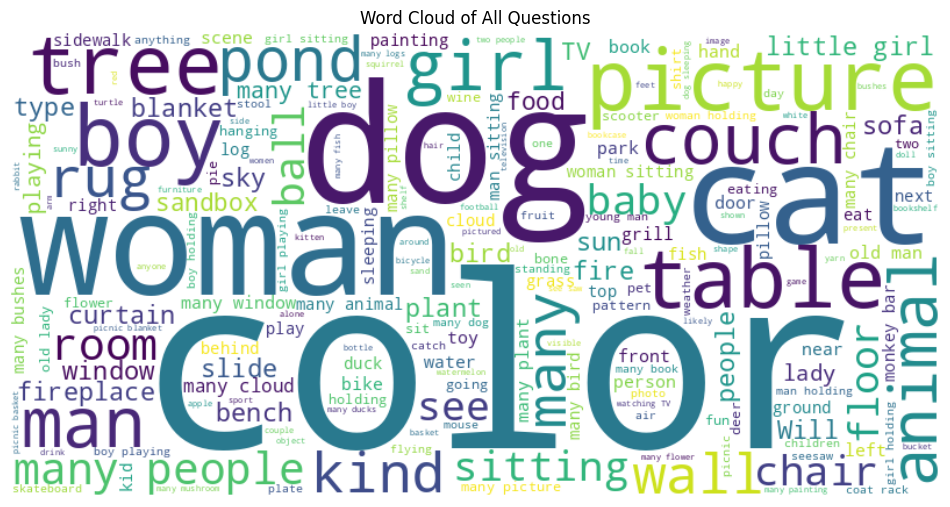

In [ ]:
# Visualize Most Common Words in Questions using a Word Cloud
all_questions = ' '.join(df_train['question'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_questions)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Questions')
plt.show()

##### Save Workspace

In [ ]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique.joblib']

### 2.2 Feature Engineering

##### Load Workspace

In [ ]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique.joblib")
df_train.head()

In [ ]:
# Apply cosine similarity-based filtering to each row
df_train['filtered_multiple_choices'] = df_train.apply(filter_choices_by_cosine_similarity, axis=1)

# View sample results
print(df_train[['question', 'multiple_choices', 'filtered_multiple_choices']].head())

                                  question  \
0          What color is the ladies pants?   
1          What color is the ladies pants?   
2          What color is the ladies pants?   
3          What color is the ladies pants?   
4  How is the equipments with bars called?   

                                    multiple_choices  \
0  [1, 3, brown, wildlife, not having tv, yellow,...   
1  [1, 3, brown, wildlife, not having tv, yellow,...   
2  [1, 3, brown, wildlife, not having tv, yellow,...   
3  [1, 3, brown, wildlife, not having tv, yellow,...   
4  [get warm, yes, playful, pug, red, fitness sys...   

                           filtered_multiple_choices  
0  [1, 3, brown, wildlife, not having tv, yellow,...  
1  [1, 3, brown, wildlife, not having tv, yellow,...  
2  [1, 3, brown, wildlife, not having tv, yellow,...  
3  [1, 3, brown, wildlife, not having tv, yellow,...  
4  [get warm, yes, playful, pug, red, fitness sys...  


In [ ]:
df_train.head()

NameError: name 'df_train' is not defined